In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



In [2]:
df = pd.read_csv('201901-fordgobike-tripdata.csv')
df = df.dropna(how='any')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S')
df['end_time'] =pd.to_datetime(df['end_time'], format='%Y-%m-%d %H:%M:%S')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,80825,2019-01-31 17:57:44.613,2019-02-01 16:24:49.864,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037,196.0,Grand Ave at Perkins St,37.808894,-122.256460,4861,Subscriber,1989.0,Male,No
1,65900,2019-01-31 20:58:33.886,2019-02-01 15:16:54.173,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,134.0,Valencia St at 24th St,37.752428,-122.420628,5506,Subscriber,1989.0,Male,No
2,62633,2019-01-31 18:06:52.924,2019-02-01 11:30:46.530,245.0,Downtown Berkeley BART,37.870139,-122.268422,157.0,65th St at Hollis St,37.846784,-122.291376,2717,Customer,1965.0,Female,No
3,44680,2019-01-31 19:46:09.719,2019-02-01 08:10:50.318,85.0,Church St at Duboce Ave,37.770083,-122.429156,53.0,Grove St at Divisadero,37.775946,-122.437777,4557,Customer,1974.0,Male,No
5,6733,2019-01-31 22:35:50.813,2019-02-01 00:28:04.512,245.0,Downtown Berkeley BART,37.870139,-122.268422,266.0,Parker St at Fulton St,37.862464,-122.264791,3532,Subscriber,1994.0,Male,No


In [3]:
start = df[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().rename(columns = {'start_station_id':'station_id', \
                                                 'start_station_name':'station_name', \
                                                 'start_station_latitude':'station_latitude', 
                                                 'start_station_longitude': 'station_longitude'})

end = df[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']].drop_duplicates().rename(columns = {'end_station_id':'station_id', \
                                             'end_station_name':'station_name', \
                                             'end_station_latitude':'station_latitude', \
                                             'end_station_longitude': 'station_longitude'})

loc = pd.concat([start, end]).drop_duplicates()
loc.head()



,station_id,station_name,station_latitude,station_longitude
0,229.0,Foothill Blvd at 42nd Ave,37.775745,-122.213037
1,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915
2,245.0,Downtown Berkeley BART,37.870139,-122.268422
3,85.0,Church St at Duboce Ave,37.770083,-122.429156
6,34.0,Father Alfred E Boeddeker Park,37.783988,-122.412408


In [5]:
def hour_segment(t):
    if t.minute < 60:
        minute = "%02d" % 0
    else:
        minute = "%02d" % 60
    return "{}-{}-{} {}:{}".format(t.year, t.month, t.day, t.hour, minute)

df['start_seg'] = [hour_segment(t) for t in df['start_time']]
df['end_seg'] = [hour_segment(t) for t in df['end_time']]

df = df.sort_values(by='start_time',ascending=True)

inflow = df[['end_station_id', 'end_seg']] \
            .groupby(['end_station_id', 'end_seg']) \
            .size().reset_index(name='counts') \
            .rename(columns={'end_station_id':'station_id','end_seg':'time', 'counts':'in_flow_count'})

outflow = df[['start_station_id', 'start_seg']] \
            .groupby(['start_station_id', 'start_seg']) \
            .size().reset_index(name='counts') \
            .rename(columns={'start_station_id':'station_id','start_seg':'time', 'counts':'out_flow_count'})

station_id_list = list(loc['station_id'])
first_segment = df['start_seg'].iloc[0]
last_segment = df['start_seg'].iloc[-1]

# time series and station ids
hour_seg_list = list(pd.date_range(first_segment, last_segment, freq="60min"))
template = pd.DataFrame(list(itertools.product(station_id_list, hour_seg_list)), columns=["station_id", "time"])

# in/out flow information
flow = pd.merge(inflow, outflow, on=['station_id', 'time'], how='outer')
flow['time'] = pd.to_datetime(flow['time'], format='%Y-%m-%d %H:%M')
flow = flow.merge(template, on=["station_id", "time"], how="right").fillna(0)
flow.head()

,station_id,time,in_flow_count,out_flow_count
0,3.0,2019-01-01 10:00:00,3.0,0.0
1,3.0,2019-01-01 11:00:00,3.0,6.0
2,3.0,2019-01-01 12:00:00,7.0,6.0
3,3.0,2019-01-01 13:00:00,5.0,6.0
4,3.0,2019-01-01 14:00:00,9.0,3.0


[-1.916847193495414, -0.2058471289838053, -0.13326102918472316, -0.10282772167738585, -0.08347306394352927, -0.07028178597647639, -0.058584167552908184, -0.05244390516236308, -0.048043595197668765, -0.04179237233438471]


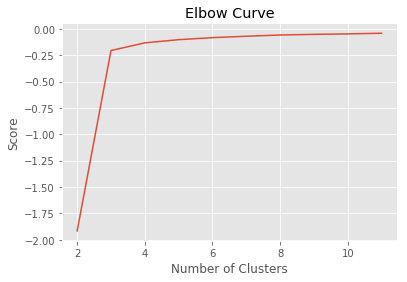

In [10]:
X = loc[['station_latitude', 'station_longitude']].values
Ks = range(2, 12)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

score = [KMeans(n_clusters=i).fit(X).score(X) for i in Ks]
print(score)

plt.plot(Ks,score)

plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()
